<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

Hello and welcome to the documentation for MCMCFF! These notebooks will guide you through the process of writing a medium sized scientific software project, discussing the decision and tradeoffs made along the way.

## Setting up your environment

It's strongly encouraged that you follow along this notebook in an enviroment where you can run the cells yourself and change them. You can either clone this git repository and run the cells in a python environment on your local machine, or if you for some reason can't do that (because you're an a phone or tablet for instance) you can instead open this notebook in [binder](link)

## The Problem

So without further ado lets talk about the problem we'll be working on, you don't necessaryily need to understand the full details of this to learn the important lessons but I will give a quick summary here. We want to simulate a physical model called the **Ising model**, which is famous in physics because it's about the simplest thing you can come up with that displays a phase transition, a special kind of shift between two different behaviours.

I'm going to weave exposition and code here so don't mind if I just take a moment to impor some packages and do some housekeeping:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# This loads some custom styles for matplotlib
import json, matplotlib
with open("assets/matplotlibrc.json") as f: matplotlib.rcParams.update(json.load(f))

We're going to be working with arrays of numbers so it will make sense to work with `Numpy` and we'll also want to plot things, the standard choice for this is `matplotlib`, though there are other options, `pandas` and `plotly` being notable ones. If this gives you an error when you run it, you might want to run `pip install numpy matplotlib` either in a terminal or in a this notebook (with an exclamation mark at the start in the latter case).

Let me quickly plot something to aid the imagination:

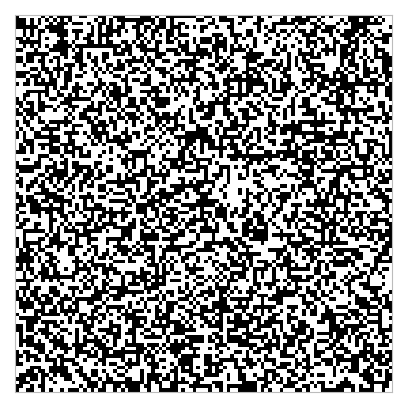

In [3]:
state = np.random.choice([-1, 1], size = (100,100))

def show_state(state, ax = None):
    if ax is None: f, ax = plt.subplots()
    ax.matshow(state, cmap = "Greys", vmin = -1, vmax = 1)
    ax.set(xticks = [], yticks = [])
    
show_state(state)

In my head, the Ising model is basically all about peer pressure. You're a tiny creature and you live in a little world where you can only be one of two things, up/down, left/right, in/out doesn't matter. 

But what *does matter* is that you're doing the same thing as you're neighbours. We're going to visualise this with images like the above, representing the two different camps, though at the moment what I've plotted is random, there's no peer pressure going on yet.

The way that a physicist would quantify this peer pressure is to assign a number to each state, lower numbers meaning more of the little creatures are doing the same thing as their neighbours. We'll call this the Energy, because physicists always call things Energy, that's just what we do.

To calculate the energy what we're gonna do is look at all the pixels/creatures, and for each one, we look at the four neighbours to the N/E/S/W, everytime we find a neighbour that agrees, we'll subtract 1 from our total and every time we find neighbours that disagree we'll add 1 to our total. Creatures at the edges will simply have fewer neighbours to worry about. 

I'll show you what the equation for this looks like, but don't worry to much about it, the word description should be enough to write some code. If we assign the ith creature the label $s_i = \pm1$ then the energy is 
$$E = \frac{1}{N} \sum_{(i,j)} s_i s_j$$
where the sum is over every two creatures who are neighbours and N is the number of them, so a $100\times100$ grid would have $N = 10,000$ 

Ok let's do some little tests, let's make the all up, all down and random state and see if we can compute their energies.

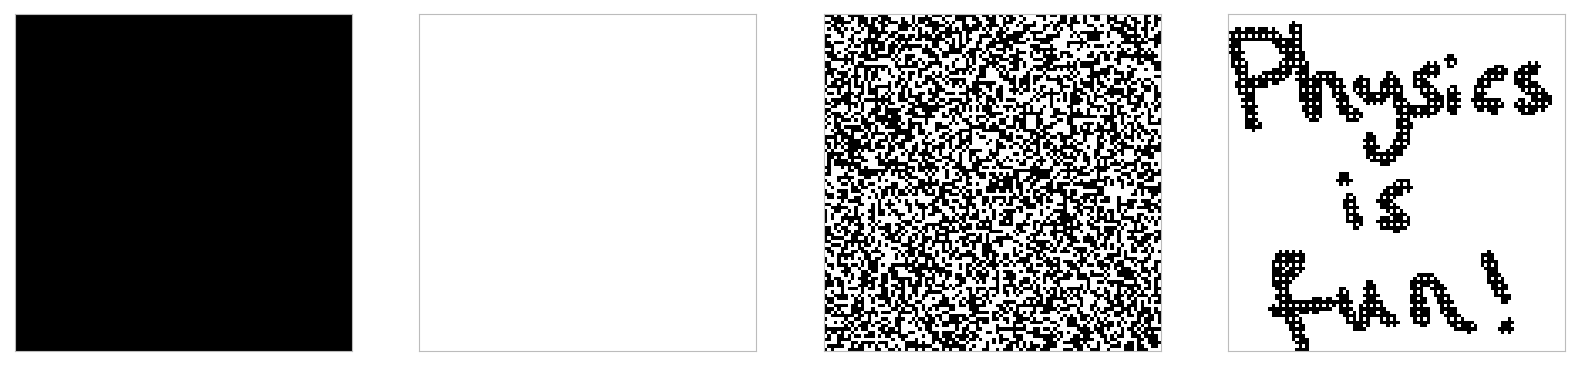

In [4]:
all_up = np.ones([100,100])
all_down = -np.ones([100,100])
random = np.random.choice([-1, 1], size = (100,100))

from matplotlib.image import imread
custom = (1 - 2*imread('data/test_state.png')[:, :, 0]) #load a 100x100 png, take the red channel, remap 0,1 to -1,1

states = [all_up, all_down, random, custom]

f, axes = plt.subplots(ncols = 4, figsize = (20,5))
for ax, state in zip(axes, states):
    show_state(state, ax = ax)

If you stare at the first two long enough you'll realise we can figure out the energy of all_up and all_down without writing any code at all:

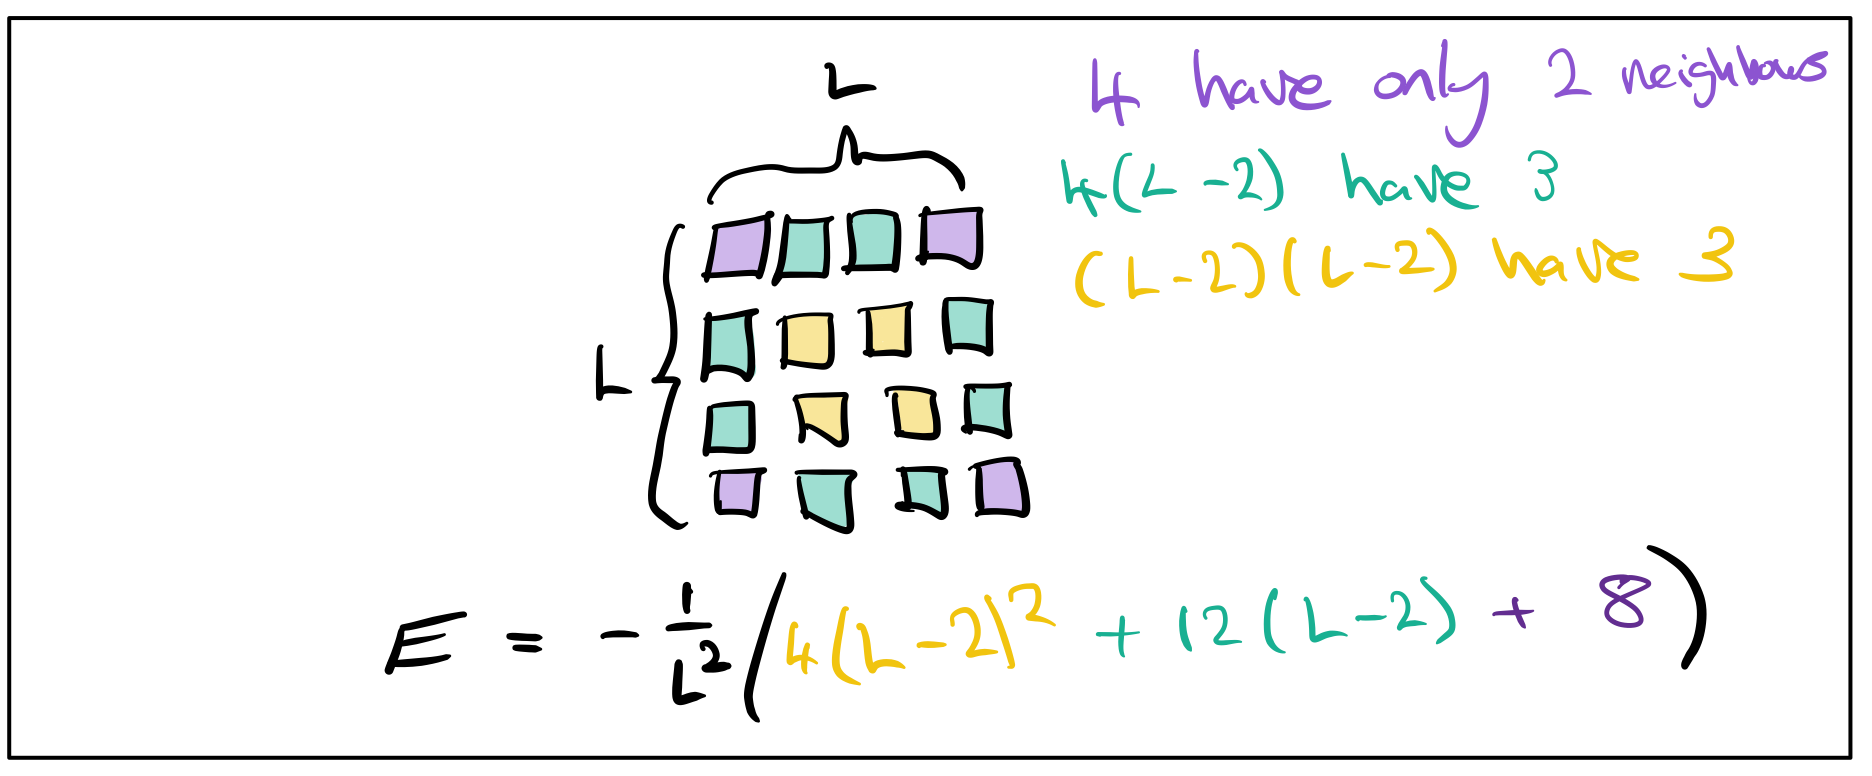
So we know that for the first two:
$$E = \frac{1}{L^2} (4(L-2)^2 + 12(L-2) + 8)$$

And for the random case we can make a pretty good guess that it should be zero on average. And the last we will just use to as a testcase.

In [5]:
def E_prediction_all_the_same(L):
    return -(4*(L - 2)**2 + 12*(L-2) + 8) / L**2

L = 100
print(f"For L = {L}, We predict E = {E_prediction_all_the_same(L)}")

For L = 100, We predict E = -3.96


## Exercise: Write a function to compute the energy of a state

See if you can write a function that calculates the energy and reproduces all the above cases. 

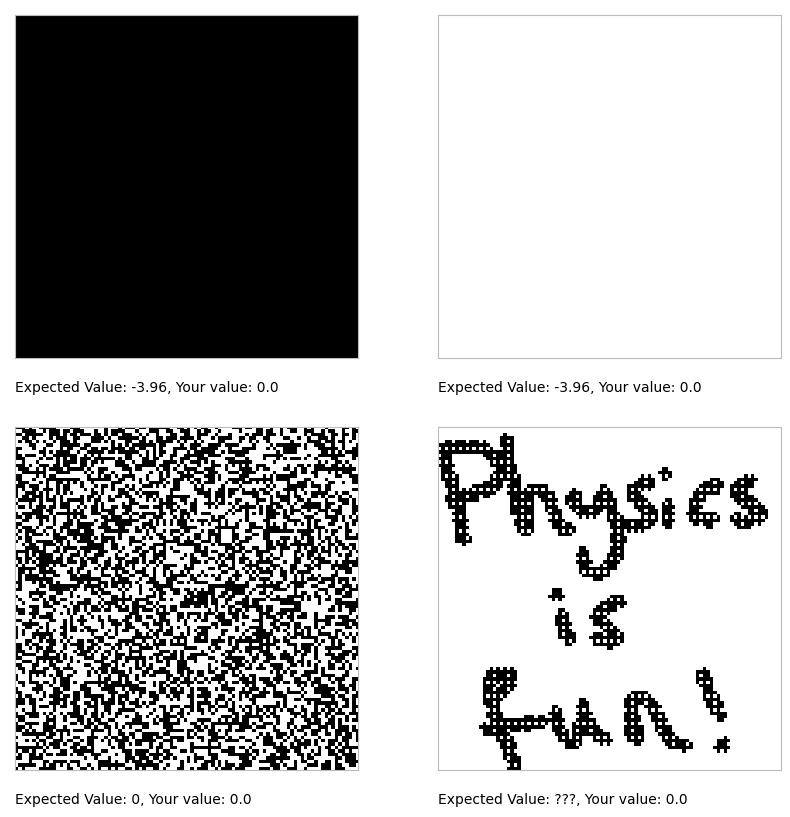

In [6]:
# you are welcome to solve this in any way you like, I've just filled out a very simple way to do it
def energy(state):
    E = 0
    N, M = state.shape
    for i in range(N):
        for k in range(M):
            # your code goes here
            pass
    return E / (N*M)
            
expected_values = [E_prediction_all_the_same(100), E_prediction_all_the_same(100), 0, '???']    

f, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))
axes = axes.flatten()
for ax, state, exp_value in zip(axes, states, expected_values):
    show_state(state, ax = ax)
    ax.text(0,-0.1, f"Expected Value: {exp_value}, Your value: {energy(state)}", transform = ax.transAxes)

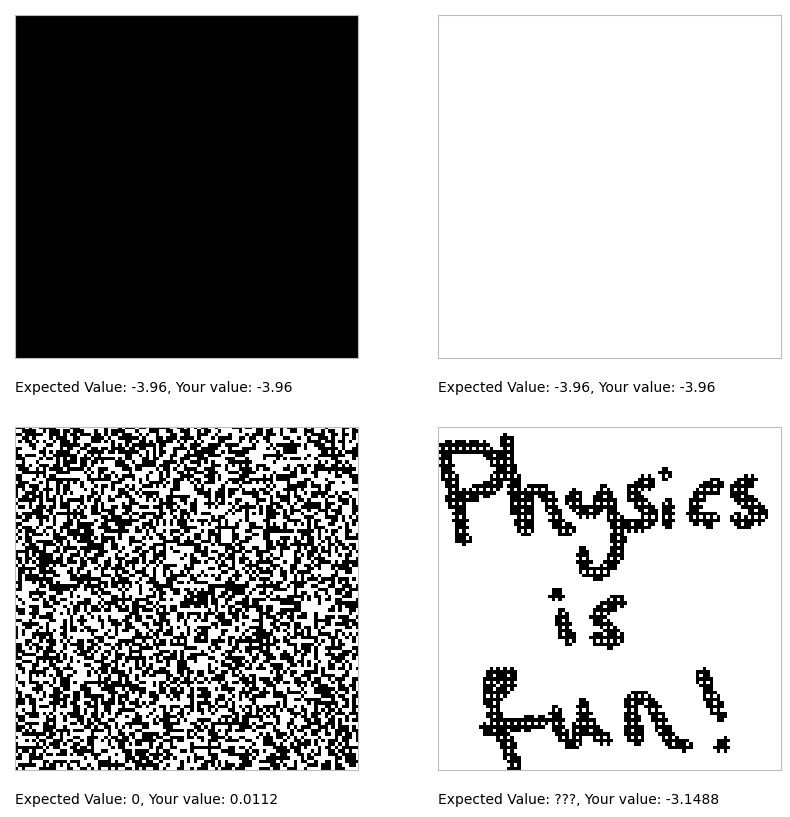

In [7]:
## Solution

def energy(state):
    E = 0
    N, M = state.shape
    for i in range(N):
        for j in range(M):
            # handle the north and south neighbours
            for di in [1, -1]:
                if 0 <= (i + di) < N:
                    E -= state[i,j] * state[i+di, j]
            
            # handle the east and west neighbours
            for dj in [1,-1]:
                if 0 <= (j + dj) < M:
                    E -= state[i,j] * state[i+di, j]
            
    return E / (N*M)
            
expected_values = [E_prediction_all_the_same(100), E_prediction_all_the_same(100), 0, '???']    

f, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))
axes = axes.flatten()
for ax, state, exp_value in zip(axes, states, expected_values):
    show_state(state, ax = ax)
    ax.text(0,-0.1, f"Expected Value: {exp_value}, Your value: {energy(state)}", transform = ax.transAxes)

It's a bit tricky to know what to do with the random value, let's try running it 100 times and see what we get:

mean = -0.0053479999999999995, standard error = 0.0037939558458158157


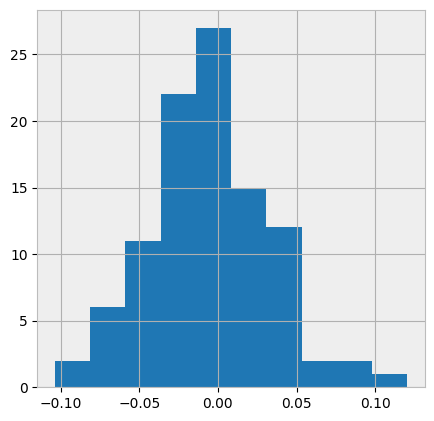

In [8]:
energies = [energy(np.random.choice([-1, 1], size = (100,100))) for _ in range(100)]
plt.hist(energies)
print(f"mean = {np.mean(energies)}, standard error = {np.std(energies) / np.sqrt(100)}")

If you run this a few times you'll see the mean is usually within two standard errors of 0, which gives us some confidence.

## Making it a little faster

## Doing Monte Carlo!

## Conclusion

In the next notebook we will start making this into a python package, which will bring a few benefits, it will set up to perform automated tests, will mean our code is not spread all about a notebook and will allow us to use the same code in mulitple places. 